# Marketing Individual Project

|Name | Student ID | 
|:-:|:-:|
| Karthick Raja Radhakrishnan | 0769173 |

# Topic: Sentiment analysis on consumer reviews of Amazon products

## Part 1 :

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import string
import re
import os
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
#!pip install unidecode
import unidecode
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout, MaxPool2D, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.layers import GlobalAvgPool1D, GlobalMaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
#!pip install keras_tuner
#import keras_tuner as kt
#!pip install wordcloud
from wordcloud import WordCloud
#!pip install prettytable
from prettytable import PrettyTable

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading Data

In [2]:
path = r"archive (3)/"
raw_df = pd.read_csv(path+"1429_1.csv").reset_index()

#Dropping records which has nulls on important columns
df = raw_df.loc[~(raw_df.asins.isna()) &  ~(raw_df['reviews.text'].isna()) &  ~(raw_df['reviews.rating'].isna()), :]\
.copy().reset_index(drop=True)

df = df.sample(frac=0.5).reset_index() #Can do analysis on only half the dataset because of resource constraint

display(df.shape)
df.head(2)

C:\Users\karth\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(17312, 23)

,level_0,index,id,name,asins,brand,categories,keys,manufacturer,reviews.date,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,26793,26828,AVpfl8cLLJeJML43AE3S,"Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,","B00L9EPT8O,B01E6AO69U",Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...","echowhite/263039693056,echowhite/152558276095,...",Amazon,2017-01-16T00:00:00.000Z,...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5588528/review...,Purchased this as a Christmas present for my w...,Great Gift for my Wife,NaN,NaN,Toad
1,11295,11319,AVphgVaX1cnluZ0-DR74,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...",B018Y229OU,Amazon,"Fire Tablets,Tablets,Computers & Tablets,All T...",firetablet7displaywifi8gbincludesspecialoffers...,Amazon,2016-01-09T00:00:00.000Z,...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5025800/review...,We've bought two now and this version is a lit...,Our 2nd one,NaN,NaN,Runmom2016


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17312 entries, 0 to 17311
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   level_0               17312 non-null  int64  
 1   index                 17312 non-null  int64  
 2   id                    17312 non-null  object 
 3   name                  13888 non-null  object 
 4   asins                 17312 non-null  object 
 5   brand                 17312 non-null  object 
 6   categories            17312 non-null  object 
 7   keys                  17312 non-null  object 
 8   manufacturer          17312 non-null  object 
 9   reviews.date          17292 non-null  object 
 10  reviews.dateAdded     12060 non-null  object 
 11  reviews.dateSeen      17312 non-null  object 
 12  reviews.didPurchase   0 non-null      object 
 13  reviews.doRecommend   17034 non-null  object 
 14  reviews.id            0 non-null      float64
 15  reviews.numHelpful 

**Important columns we require for our analysis**

**ASIN:** stands for Amazon Standard Identification Number. It’s a unique identifier of 10 letters and/or numbers for a product that’s assigned by Amazon.com.

**reviews.text** is the reviews provided by different users for various Amazon products

**reviews.rating** is the rating provided for different Amazon products

We also need a target variable sentiment to be derived from ratings.

In [4]:
# Creating a target variable sentiment for sentiment analysis
df['reviews.sentiment'] = df['reviews.rating'].map({1:0,2:0,3:0,4:1,5:1}).copy()
df['reviews.sentiment']

0        1
1        1
2        1
3        1
4        1
        ..
17307    1
17308    1
17309    1
17310    1
17311    1
Name: reviews.sentiment, Length: 17312, dtype: int64

### Exploratory Data Analysis

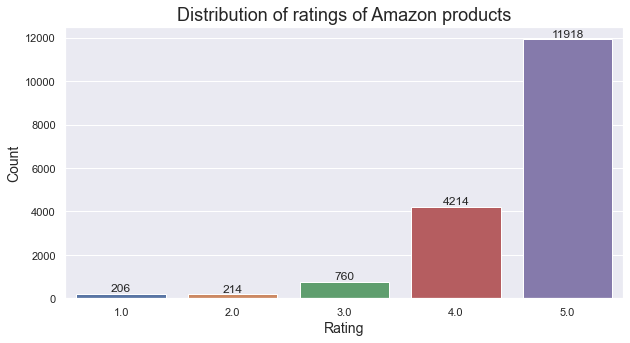

In [5]:
import seaborn as sns
sns.set()

fig = plt.figure(figsize=(10, 5))

ax = sns.countplot(data = df, x='reviews.rating')

labels = df['reviews.rating'].value_counts(ascending=True).values

ax.bar_label(container=ax.containers[0], labels=labels)

plt.xlabel('Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.title('Distribution of ratings of Amazon products',fontsize=18)
plt.show()

* Most of the users provided 5 or 4 star ratings for Amazon products

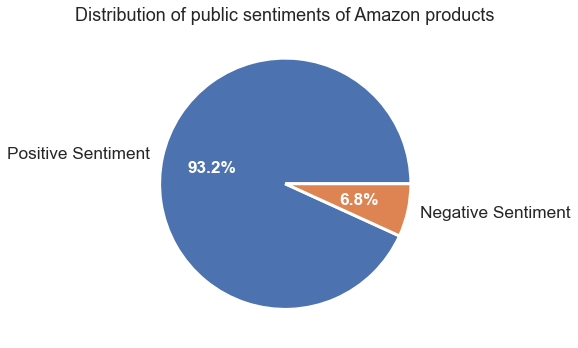

In [6]:
import seaborn as sns
sns.set()

fig, ax = plt.subplots(figsize=(15, 5))

data = df['reviews.sentiment'].value_counts()*100/len(df['reviews.sentiment'])

labels = data.index.map({1:'Positive Sentiment', 0:'Negative Sentiment'})

# Capture each of the return elements.
patches, texts, pcts = ax.pie(
    data, labels=labels, autopct='%.1f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})

# Style just the percent values.
plt.setp(pcts, color='white', fontweight='bold')
ax.set_title('Distribution of public sentiments of Amazon products', fontsize=18)
plt.tight_layout()

* If we were to build a model, our baseline accuracy is 93.6% (for the whole data), if the model predicts all the reviews as positive sentiment.

* This also shows that most of the users, who gave a review liked the Amazon products overall.

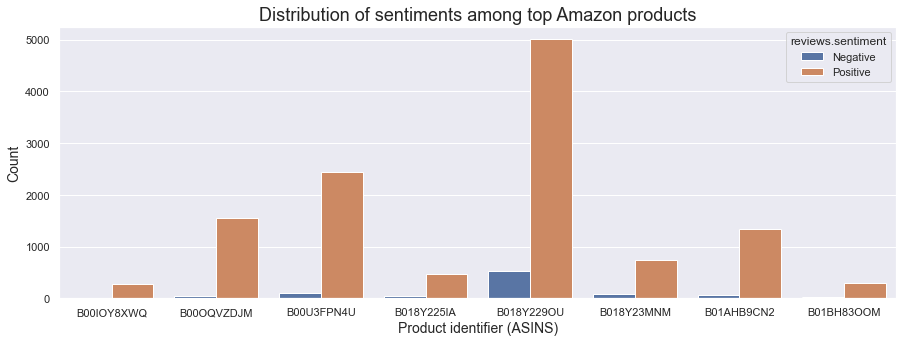

In [7]:
import seaborn as sns
sns.set()

fig = plt.figure(figsize=(15, 5))

data = df.groupby(['asins', 'reviews.sentiment'])['reviews.rating'].count().reset_index().rename(columns={'reviews.rating':'count'})

#Manually foundout the top Amazon products based on number of reveiws.
data = data.loc[data['asins'].isin(["B018Y229OU","B00L9EPT8O","B01E6AO69U","B00U3FPN4U","B00OQVZDJM","B01AHB9CN2","B018Y23MNM","B018Y229OU","B018Y225IA","B01BH83OOM","B00IOY8XWQ"]), :]

data['reviews.sentiment'] = data['reviews.sentiment'].map({0:'Negative', 1:'Positive'})

ax = sns.barplot(data=data, x="asins", y="count", hue='reviews.sentiment')
#ax.set_xticklabels(data['count'].values)

plt.xlabel('Product identifier (ASINS)', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.title('Distribution of sentiments among top Amazon products',fontsize=18)
plt.show()

* As you can see, even for the top reviewed Amazon products, negative sentiment is way less in proportion.

### Text Cleaning and Processing

In [8]:
# Do the same steps for all the reviews in the dataset using the for loop

corpus = np.empty(len(df['reviews.text']), dtype='object') # Build a new list for all the words from all the reviews

# corpus is a collection of text and a common term used in NLP
for i in range(0, len(df['reviews.text'])):  
    text = re.compile(r'<.*?>').sub(r"",df['reviews.text'][i]) #Remove HTML
    text = re.compile(r"https://\S+|www\.\S+").sub(r"", df.loc[i,'reviews.text']) #Remove URl
    text = re.compile(r'[^\w\s]').sub(r"", text) #Remove punctuaation
    text = unidecode.unidecode(text) #Removing Special characters
    text = text.lower() #change to lower case
    text = text.split()
    Lemmatizer =WordNetLemmatizer()
    """Apply stemming technique and remove stopwords"""
    text = (Lemmatizer.lemmatize(word) for word in text if word not in set(stopwords.words('english')))
    text = ' '.join(text)
    corpus[i] = text

In [9]:
corpus

array(['purchased christmas present wife love mostly play music im sure usage expand time go',
       'weve bought two version little lighter wlarger screen like first one really simple use call tablet theyre super afordable worth first one double price couldnt pas deal still work great dropped many time toddler feature child version think great product',
       'absolutely love fire tablet great size lot space great reader cant recommend product enough',
       ...,
       'thought would bland 8 year old love game book apps great age range parental control kept honest',
       'gift daughter christmas love',
       'wanted tablet would fit purse easy use would buy'], dtype=object)

* Created a corpus of all the reviews after cleaning the texts completely.
* Used stemming technique lemmatizer to lemmatize the words. (For example: Studying, Studeied chaanged to study)
* Need to create a wordcloud for both positive and negative sentiments to find if customers need anything or to find something interesting as well.

### Word cloud

#### Positive reviews

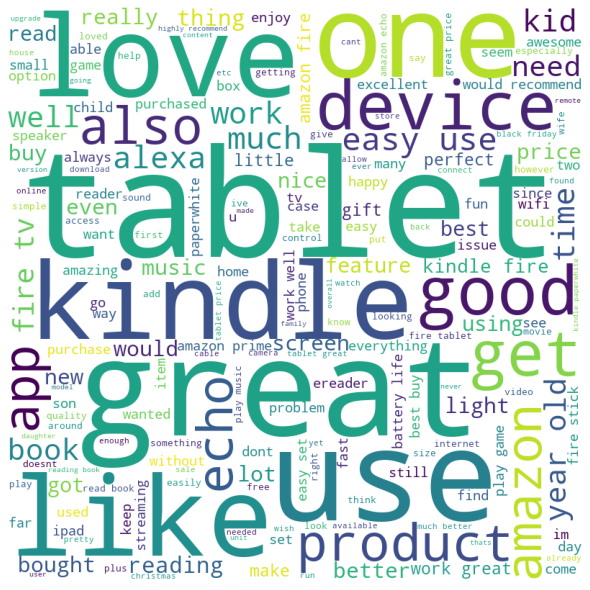

In [10]:
positive_reviews = np.array(corpus)[df['reviews.sentiment']==1]

def Build_WordCloud(reviews):
    STOPWORDS = set(stopwords.words('english'))
    words = ""
    
    for review in reviews:
        words += "".join(review)+""
 
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    min_font_size = 10).generate(words)
     
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
     
    plt.show()
    

Build_WordCloud(positive_reviews)

* Lot of positives words can be seen like "love", "like", "great", "use" depicted large, it means these positive words were used by many reviewers.

* We can see a products tablet and kindle being used multiple times as well.

* We can also see few negaative words like "doesn't" but that is gotten sideshadowed by the list of positive words.

#### Negative sentiments

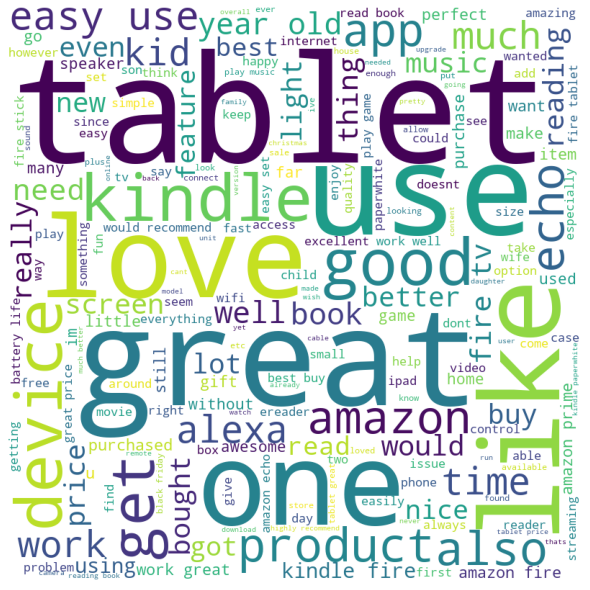

In [11]:
negative_reviews = np.array(corpus)[df['reviews.sentiment']==0]
Build_WordCloud(positive_reviews)

* We can still see a lot of positive words in negative reviews as well.

* There are some words which seems interesting to be a negative rating. For example: Need, much, little, old etc.,

* These words can mean negative or positive depending on the phrase the reviewers use it.

### Suggestions based on analysis

* Tablet and kindle products seems to have more positive and negative reviews, so these products can be looked upon even more.

* We can see the words 'need' and 'could', which suggests the user need something out of the product, so we suggest looking into the reviews with these words.

* Modelling an algorithm to classify the review into positive or negative sentiment can be useful to predict sentiment of anyother review about the product, which doesn't have any rating.

## Part 2: Classification of reviews into sentiments using Rating

### Feature Selection

**Bag of words approach**

In [12]:
# Create the bag of words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features= 1500) # We restrict the words to 1500 which keeps the most frequent words

In [13]:
X = cv.fit_transform(corpus).toarray() # independent variables
X.shape

(17312, 1500)

In [14]:
y = df[['reviews.sentiment']] # dependent variable (These are your Liked values from the dataset)
y.shape

(17312, 1)

As per the above results, we can see the number of reviews and ratings provided for different Amazon products.

#### Splitting the data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

### Modeling

#### SVM model

C:\Users\karth\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


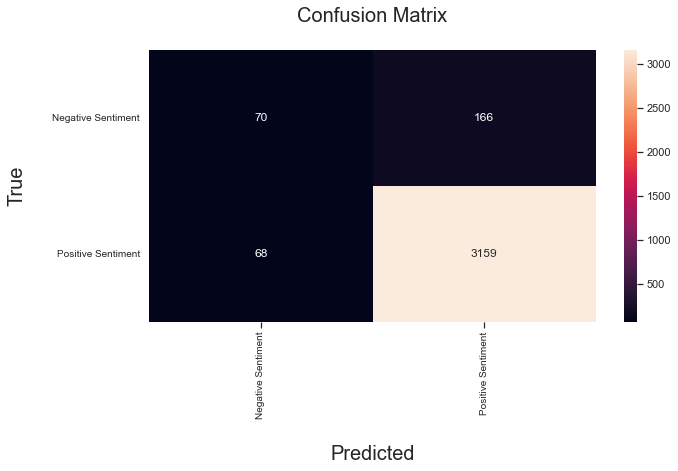

Accuracy:	 0.93 
 Precision:	 0.95 
 Recall:	 0.98 
 F1 measure:	 0.96 



In [16]:
from sklearn import svm

# Fitting classifier to the Training set
svm_clf = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=1)
svm_clf = svm_clf.fit(X_train, y_train)

# Predicting the Test set results 
y_pred = svm_clf.predict(X_test)

# Make the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Class Labels
class_names = ["Negative Sentiment", "Positive Sentiment"]

# Plotting Confusion matrix
cm = confusion_matrix(y_test, y_pred)  

def plot_confusion_matrix(cm, class_names=class_names, figsize=(10, 5)):
    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=figsize)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('\nPredicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_names, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True\n', fontsize=20)
    ax.yaxis.set_ticklabels(class_names, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix\n', fontsize=20)
    plt.show()
    
plot_confusion_matrix(cm)

# Evaluate the results
evaluation_results = dict([("Bag of Words approach",dict([("SVM",[round(accuracy_score(y_test,y_pred), 2),
                                                         round(precision_score(y_test,y_pred), 2),
                                                         round(recall_score(y_test,y_pred), 2),
                                                         round(f1_score(y_test,y_pred), 2)
                                                           ]
                                                       )
                                                      ]
                                                     )
                           )])

print("Accuracy:\t",evaluation_results['Bag of Words approach']['SVM'][0],"\n",
      "Precision:\t",evaluation_results['Bag of Words approach']['SVM'][1],"\n",
      "Recall:\t",evaluation_results['Bag of Words approach']['SVM'][2],"\n",
      "F1 measure:\t",evaluation_results['Bag of Words approach']['SVM'][3],"\n"
     )

#### RNN model (LSTM)

In [17]:
def model(input_dim,
          output_dim,
          input_length,
          num_units = 512,
          num_lstm_layers = 1,
          dropout_rate = 0.4,
          recurrent_dropout = 0,
          num_hidden_layers = 0,
          num_dense_units = 256,
          dense_dropout = 0.4,
          optimizer = tf.keras.optimizers.SGD(),
          pooling = True,
          pooling_type = 'global_avg'
         ):
    
    model = Sequential()
    
    #Embedding layer to embed the text vectors as an encoded data so, it can be input for the model
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)) 
    
    #LSTM block
    for i in range(num_lstm_layers):
          model.add(LSTM(num_units, 
                         dropout=dropout_rate, 
                         activation='tanh', 
                         recurrent_activation='sigmoid',
                         recurrent_dropout=recurrent_dropout, 
                         use_bias=True, 
                         unroll=False,
                         return_sequences=True
                        ))
    
    #Pooling layers to reduce dimentions and so, to reduce parameters
    if pooling:
        if pooling_type=='global_avg':
            model.add(GlobalAvgPool1D())
        if pooling_type=='global_max':
            model.add(GlobalMaxPool1D())
    else:
    #Flattening the 2D array to 1D before passing to Fully-Connected network or to the output layer
      model.add(Flatten())
    
    #Fully-Connected layers
    for i in range(num_hidden_layers):
        model.add(Dense(num_dense_units, activation='relu'))
        model.add(Dropout(dense_dropout))
    model.add(Dense(1, activation="sigmoid")) #Using two nodes as ouput

    #Compiling the model (for backpropogation)
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = optimizer,
        metrics = ["accuracy"]
    )
    
    return model

input_dim = len(corpus) #Size of the vocabulary i.e. maximum integer index + 1
#df['reviews.text'].apply(lambda x: len(x)).max()+1
output_dim = 10 #Dimention of the dense embedding layer

input_length = X_train.shape[-1] #number of columns after vectorization should be provided here

tf.keras.backend.clear_session()

model = model(input_dim=input_dim, 
              output_dim=output_dim, 
              num_lstm_layers=1,
              num_units = 128,
              dropout_rate = 0.2,
              recurrent_dropout = 0,
              input_length=input_length, 
              pooling=False,
              num_hidden_layers=1,
              num_dense_units = 128,
              dense_dropout = 0.2,
              optimizer = tf.keras.optimizers.Adam()
             )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 10)          173120    
                                                                 
 lstm (LSTM)                 (None, 1500, 128)         71168     
                                                                 
 flatten (Flatten)           (None, 192000)            0         
                                                                 
 dense (Dense)               (None, 128)               24576128  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 24,820,545
Trainable params: 24,820,545
No

#### Training and Validation

In [18]:
EPOCHS = 10
BATCH_SIZE = 256

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="lstm.keras",
                                            save_best_only=True,
                                            monitor='val_loss')

history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, 
                    callbacks=[checkpoint]
                   )

Epoch 1/10
44/44 [==============================] - 22s 425ms/step - loss: 0.2719 - accuracy: 0.9170 - val_loss: 0.2387 - val_accuracy: 0.9350
Epoch 2/10
44/44 [==============================] - 18s 420ms/step - loss: 0.2524 - accuracy: 0.9310 - val_loss: 0.2377 - val_accuracy: 0.9347
Epoch 3/10
44/44 [==============================] - 18s 416ms/step - loss: 0.2406 - accuracy: 0.9310 - val_loss: 0.2075 - val_accuracy: 0.9350
Epoch 4/10
44/44 [==============================] - 19s 439ms/step - loss: 0.2099 - accuracy: 0.9316 - val_loss: 0.1904 - val_accuracy: 0.9354
Epoch 5/10
44/44 [==============================] - 18s 418ms/step - loss: 0.1928 - accuracy: 0.9358 - val_loss: 0.1870 - val_accuracy: 0.9383
Epoch 6/10
44/44 [==============================] - 19s 434ms/step - loss: 0.1757 - accuracy: 0.9411 - val_loss: 0.1844 - val_accuracy: 0.9368
Epoch 7/10
44/44 [==============================] - 13s 290ms/step - loss: 0.1678 - accuracy: 0.9443 - val_loss: 0.1892 - val_accuracy: 0.9365

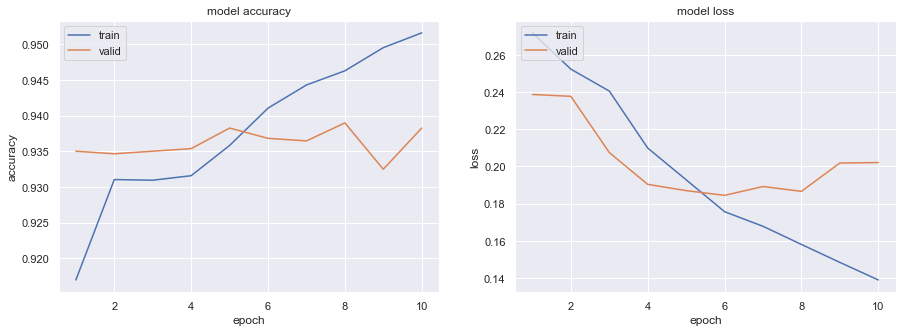

In [19]:
def plot_train_val_accuracy_n_loss(history, Range=2.0):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for ax, j in zip(axes, ['accuracy', 'loss']):
        # summarize history for accuracy and loss
        ax.plot(range(1, len(history.history[j]) + 1), history.history[j])
        ax.plot(range(1, len(history.history['val_'+j]) + 1), history.history['val_'+j])
        ax.set_title("model "+j)
        ax.set_ylabel(j)
        ax.set_xlabel('epoch')
        ax.set_xticks(np.arange(2,EPOCHS+1, Range))
        ax.legend(['train', 'valid'], loc='upper left')
    plt.show()
        
plot_train_val_accuracy_n_loss(history)

#### Testing

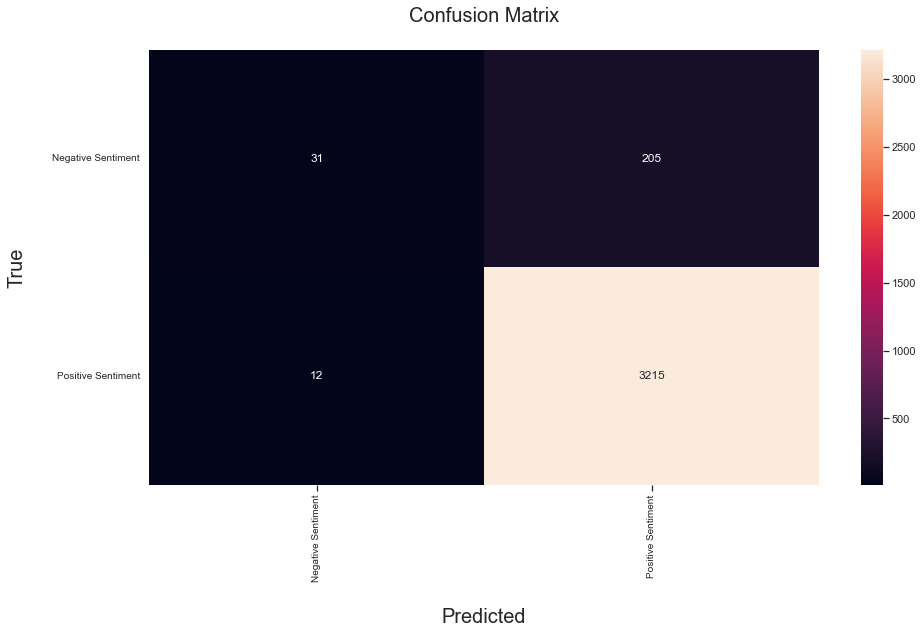

 Accuracy:	 0.94 
 Precision:	 0.94 
 Recall:	 1.0 
 F1 measure:	 0.97 



In [20]:
model = tf.keras.models.load_model("lstm.keras")

y_pred = (model.predict(X_test)>0.5).astype(np.int32)

class_names = ["Negative Sentiment", "Positive Sentiment"]

# Plotting Confusion matrix
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, class_names=class_names):
    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(15, 8))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('\nPredicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_names, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True\n', fontsize=20)
    ax.yaxis.set_ticklabels(class_names, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix\n', fontsize=20)
    plt.show()

plot_confusion_matrix(cm)

#Evaluate the results
evaluation_results['Bag of Words approach']['RNN']=[round(accuracy_score(y_test,y_pred), 2),
                                                 round(precision_score(y_test,y_pred), 2),
                                                 round(recall_score(y_test,y_pred), 2),
                                                 round(f1_score(y_test,y_pred), 2)
                                                ]

print(" Accuracy:\t",evaluation_results['Bag of Words approach']['RNN'][0],"\n",
      "Precision:\t",evaluation_results['Bag of Words approach']['RNN'][1],"\n",
      "Recall:\t",evaluation_results['Bag of Words approach']['RNN'][2],"\n",
      "F1 measure:\t",evaluation_results['Bag of Words approach']['RNN'][3],"\n"
     )

### Feature selection

**TF IDF Approach**

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))

In [22]:
X = vectorizer.fit_transform(corpus).toarray()

In [23]:
X.shape

(17312, 2392)

#### Splitting the data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

### Modeling

#### SVM model

C:\Users\karth\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


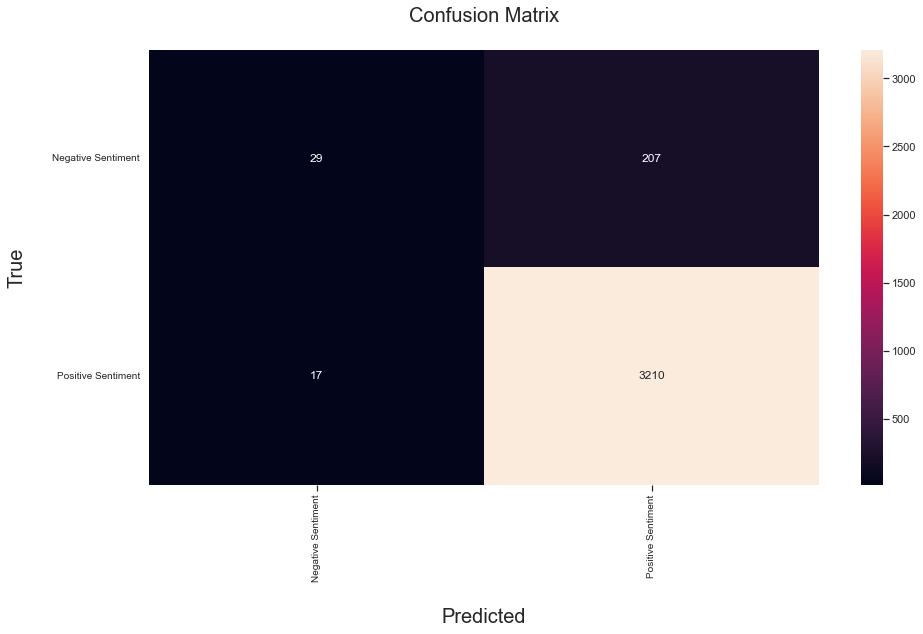

 Accuracy:	 0.94 
 Precision:	 0.94 
 Recall:	 0.99 
 F1 measure:	 0.97 



In [25]:
from sklearn import svm

# Fitting classifier to the Training set
svm_clf = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=1)
svm_clf = svm_clf.fit(X_train, y_train)

# Predicting the Test set results 
y_pred = svm_clf.predict(X_test)

# Make the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Class Labels
class_names = ["Negative Sentiment", "Positive Sentiment"]

# Plotting Confusion matrix
cm = confusion_matrix(y_test, y_pred)
    
plot_confusion_matrix(cm)

#Evaluate the results
evaluation_results['TF IDF approach'] = dict()
evaluation_results['TF IDF approach']['SVM']=[round(accuracy_score(y_test,y_pred), 2),
                                                 round(precision_score(y_test,y_pred), 2),
                                                 round(recall_score(y_test,y_pred), 2),
                                                 round(f1_score(y_test,y_pred), 2)
                                                ]

print(" Accuracy:\t",evaluation_results['TF IDF approach']['SVM'][0],"\n",
      "Precision:\t",evaluation_results['TF IDF approach']['SVM'][1],"\n",
      "Recall:\t",evaluation_results['TF IDF approach']['SVM'][2],"\n",
      "F1 measure:\t",evaluation_results['TF IDF approach']['SVM'][3],"\n"
     )

#### RNN model (LSTM)

In [26]:
def model(input_dim,
          output_dim,
          input_length,
          num_units = 512,
          num_lstm_layers = 1,
          dropout_rate = 0.4,
          recurrent_dropout = 0,
          num_hidden_layers = 0,
          num_dense_units = 256,
          dense_dropout = 0.4,
          optimizer = tf.keras.optimizers.SGD(),
          pooling = True,
          pooling_type = 'global_avg'
         ):
    
    model = Sequential()
    
    #Embedding layer to embed the text vectors as an encoded data so, it can be input for the model
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)) 
    
    #LSTM block
    for i in range(num_lstm_layers):
          model.add(LSTM(num_units, 
                         dropout=dropout_rate, 
                         #activation='tanh', 
                         #recurrent_activation='sigmoid',
                         recurrent_dropout=recurrent_dropout, 
                         #use_bias=True, 
                         #unroll=False,
                         return_sequences=True
                        ))
    
    #Pooling layers to reduce dimentions and so, to reduce parameters
    if pooling:
        if pooling_type=='global_avg':
            model.add(GlobalAvgPool1D())
        if pooling_type=='global_max':
            model.add(GlobalMaxPool1D())
    else:
    #Flattening the 2D array to 1D before passing to Fully-Connected network or to the output layer
      model.add(Flatten())
    
    #Fully-Connected layers
    for i in range(num_hidden_layers):
        model.add(Dense(num_dense_units, activation='relu'))
        model.add(Dropout(dense_dropout))
    model.add(Dense(1, activation="sigmoid")) #Using two nodes as ouput

    #Compiling the model (for backpropogation)
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = optimizer,
        metrics = ["accuracy"]
    )
    
    return model

input_dim = len(corpus) #Size of the vocabulary i.e. maximum integer index + 1

output_dim = 10 #Dimention of the dense embedding layer

input_length = X_train.shape[-1] #number of columns after vectorization should be provided here

tf.keras.backend.clear_session()

model = model(input_dim=input_dim, 
              output_dim=output_dim, 
              num_lstm_layers=2,
              num_units = 64,
              dropout_rate = 0.2,
              recurrent_dropout = 0,
              input_length=input_length,
              pooling=False,
              num_hidden_layers=1,
              num_dense_units = 128,
              dense_dropout = 0.2,
              optimizer = tf.keras.optimizers.Adam()
             )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2392, 10)          173120    
                                                                 
 lstm (LSTM)                 (None, 2392, 64)          19200     
                                                                 
 lstm_1 (LSTM)               (None, 2392, 64)          33024     
                                                                 
 flatten (Flatten)           (None, 153088)            0         
                                                                 
 dense (Dense)               (None, 128)               19595392  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

#### Training and validation

Epoch 1/10
44/44 [==============================] - 34s 656ms/step - loss: 0.2933 - accuracy: 0.9134 - val_loss: 0.2470 - val_accuracy: 0.9350
Epoch 2/10
44/44 [==============================] - 26s 594ms/step - loss: 0.2547 - accuracy: 0.9310 - val_loss: 0.2406 - val_accuracy: 0.9350
Epoch 3/10
44/44 [==============================] - 23s 522ms/step - loss: 0.2555 - accuracy: 0.9310 - val_loss: 0.2545 - val_accuracy: 0.9350
Epoch 4/10
44/44 [==============================] - 27s 613ms/step - loss: 0.2578 - accuracy: 0.9310 - val_loss: 0.2406 - val_accuracy: 0.9350
Epoch 5/10
44/44 [==============================] - 25s 564ms/step - loss: 0.2552 - accuracy: 0.9310 - val_loss: 0.2407 - val_accuracy: 0.9350
Epoch 6/10
44/44 [==============================] - 25s 578ms/step - loss: 0.2555 - accuracy: 0.9310 - val_loss: 0.2409 - val_accuracy: 0.9350
Epoch 7/10
44/44 [==============================] - 23s 520ms/step - loss: 0.2561 - accuracy: 0.9310 - val_loss: 0.2480 - val_accuracy: 0.9350

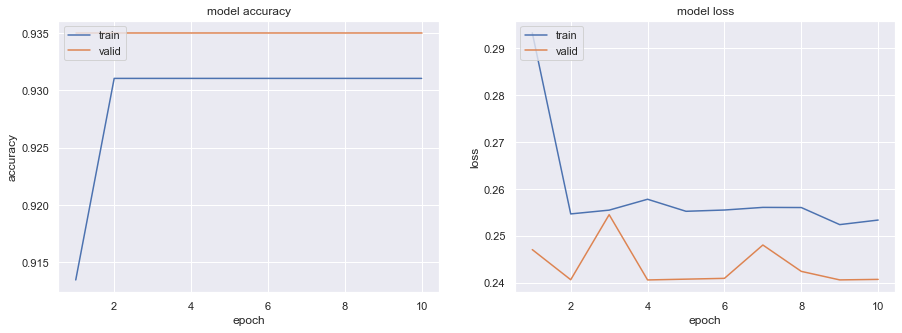

In [27]:
EPOCHS = 10
BATCH_SIZE = 256

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="lstm.keras",
                                            save_best_only=True,
                                            monitor='val_loss')

history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, 
                    callbacks=[checkpoint]
                   )

plot_train_val_accuracy_n_loss(history)

#### Testing

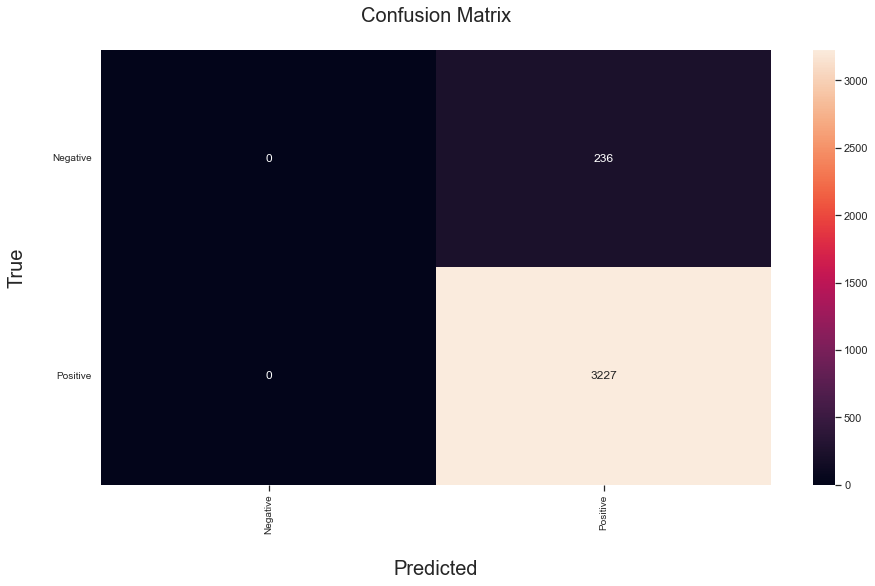

Accuracy:	 0.93 
 Precision:	 0.93 
 Recall:	 1.0 
 F1 measure:	 0.96 



In [28]:
model = tf.keras.models.load_model("lstm.keras")

y_pred = (model.predict(X_test)>0.5).astype(np.int32)

class_names = ["Negative", "Positive"]

# Plotting Confusion matrix
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, class_names=class_names):
    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(15, 8))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('\nPredicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_names, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True\n', fontsize=20)
    ax.yaxis.set_ticklabels(class_names, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix\n', fontsize=20)
    plt.show()

plot_confusion_matrix(cm)

#Evaluate the results
evaluation_results['TF IDF approach']['RNN']=[round(accuracy_score(y_test,y_pred), 2),
                                                 round(precision_score(y_test,y_pred), 2),
                                                 round(recall_score(y_test,y_pred), 2),
                                                 round(f1_score(y_test,y_pred), 2)
                                                ]

print("Accuracy:\t",evaluation_results['TF IDF approach']['RNN'][0],"\n",
      "Precision:\t",evaluation_results['TF IDF approach']['RNN'][1],"\n",
      "Recall:\t",evaluation_results['TF IDF approach']['RNN'][2],"\n",
      "F1 measure:\t",evaluation_results['TF IDF approach']['RNN'][3],"\n"
     )

### Comparing the various models on both the approaches

In [29]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

print(color.BOLD + 'Bag of Words Model:\n' + color.END)


def pretty_table(Approach):
    myTable = PrettyTable(["Model", "Accuracy", "Precision", "Recall", "F1-measure"]) 
  
    # Add rows 
    myTable.add_row(["RNN Model",
                     evaluation_results[Approach]['RNN'][0],
                     evaluation_results[Approach]['RNN'][1],
                     evaluation_results[Approach]['RNN'][2],
                     evaluation_results[Approach]['RNN'][3]]) 
    myTable.add_row(["SVM Model",
                     evaluation_results[Approach]['SVM'][0],
                     evaluation_results[Approach]['SVM'][1],
                     evaluation_results[Approach]['SVM'][2],
                     evaluation_results[Approach]['SVM'][3]])
    return myTable
    
display(pretty_table("Bag of Words approach"))

print(color.BOLD + '\nTF-IDF (term frequency-inverse document frequency):\n' + color.END)

display(pretty_table("TF IDF approach"))

Bag of Words Model:



Model,Accuracy,Precision,Recall,F1-measure
RNN Model,0.94,0.94,1.0,0.97
SVM Model,0.93,0.95,0.98,0.96



TF-IDF (term frequency-inverse document frequency):



Model,Accuracy,Precision,Recall,F1-measure
RNN Model,0.93,0.93,1.0,0.96
SVM Model,0.94,0.94,0.99,0.97


**RNN Model**

* RNN model on TF IDF approach cannot seem to be predicting the negative sentiment as it predicts  everything as a positive sentiment and from the graph, we can tell it is not learning anything between epochs.

* We might need to fine tune it or we need to send bigrams or multigrams for a better prediction instead of a word.

* RNN model from bags of model approaach produces good results as you can see from the four metrics and confusion matrix.

**SVM Model**

* SVM model on both approaches seems to  be able to predict and providing good results accross four metrics.


SVM model or RNN model with the bag of words approach is the best way to go as it provides good scores for all metrics on average.